# Machine Learing

## Introduction

The purpose of our analysis was to determine  the winner of a Basketball game, as a function of the
data gathered at half-time.


##Importing all the needed libraries.


In [1]:
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np

## Download dataset

In [2]:
url1 = "./inputs.npy"
url2 = "./labels.npy"
inputs = np.load(url1)
labels = np.load(url2)
dataset = pd.DataFrame(inputs)

First we need to split our dataset into two separate dataset, train and validation.

We will use the train set to train our model, then use the validation one to test our model.

X and Y represente respectively the data gathered at half time and the result, wich is winning the match or not.

In [4]:
array = dataset.values
X = array[:,0:]
y = array[:,-1]
X_train, X_validation, Y_train, Y_validation = train_test_split(inputs, labels[:,0], test_size=0.20, random_state=2, shuffle=True)

## Choice of algorithm

We compile and test together 6 algorithms to determine the one with the better accuracy.

In [5]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(gamma='auto')))

Time to test them all.

In [6]:
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.897500 (0.068420)
LDA: 0.902500 (0.048023)
CART: 0.717500 (0.083703)
NB: 0.747500 (0.058577)
KNN: 0.645000 (0.065955)
SVM: 0.522500 (0.007500)


For each algorithm, the first number represent the average accuity and the number in parenthesis the standard deviation.

We use some box plot to have a better view of those result.

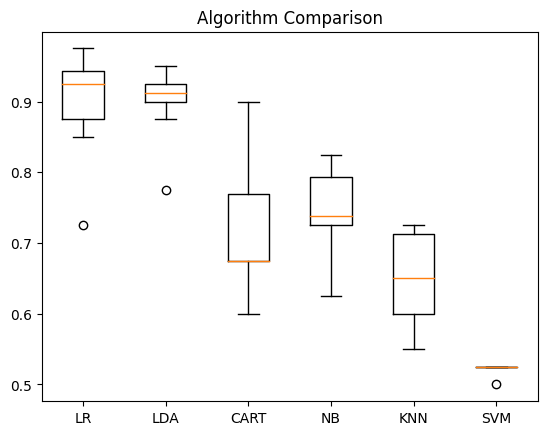

In [7]:
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

Has we can see, the linear discriminant analysis(LDA) have the best result. We will use this one to train our model.

##Hyperparameter

Before training it, we need to determine the hyperpameter.

We split again the dataset but we wil just remove the last data to verify the result.

In [8]:
data = dataset.values
X, y = data[:, :-1], data[:, -1]

We load the model we choosed.

In [9]:
model = LinearDiscriminantAnalysis()

The modele will be evaluate using a repeated stratified kfold with 10 folds.

In [10]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

Then we define the parameter that will be tested, which are 'solver' and 'shrinkage'.

In [14]:
grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']
grid['shrinkage'] = np.arange(0, 1, 0.01)

To do the search we will use a grid search, which is the exhaustive way to doing it

In [15]:
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)

Then we can see the result of the search

In [19]:
result = search.fit(inputs, labels[:,0])
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8986666666666667
Best Hyperparameters: {'shrinkage': 0.01, 'solver': 'lsqr'}
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3000 fits failed out of a total of 9000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3000 fits failed with the following error:
Traceback (most recent call last):
  File "/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/discriminant_analysis.py", line 589, in fit
    raise NotImplementedError("shrinkage not supported")
NotImplementedError:

We can see that the better solver is lsqr wit a shrinh=kage of 0.1

##Training

We will now train the chosen model with the hyperparameter and the training dataset.

In [17]:
model = LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr')
model.fit(X_train, Y_train)
training = model.predict(X_validation)

And to finish, we print the accuracy score, the confusion matrix and the classification report.

In [18]:
print(accuracy_score(Y_validation, training))
print(confusion_matrix(Y_validation, training))
print(classification_report(Y_validation, training))

0.88
[[43  5]
 [ 7 45]]
              precision    recall  f1-score   support

        -1.0       0.86      0.90      0.88        48
         1.0       0.90      0.87      0.88        52

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100



##Conclusion

After training the model, it was able to determine correctly the outcome of 88% of the match.
Of 100 matches, only 5 were given a false positive and 7 a true negative.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=abec5b1b-329a-444c-9b38-bb5be6b4b415' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>